In [5]:
import pandas as pd
import os
import io
from IPython.display import display
import cufflinks as cf
cf.go_offline()
import plotly.io as pio
import plotly.graph_objects as go
import requests
pio.renderers.default = 'colab'
df = pd.read_csv('../raw_data/extracted_from_reports/hospitalizations_per_province.csv', index_col=['date', 'province'], parse_dates=['date','report_date'])

In [16]:
# plot total cases per day, by reported date
df['report_date_str'] = df['report_date'].apply(lambda x: x.strftime('%m-%d'))
d = df.pivot_table(index='date', columns=['report_date_str'], values='value', aggfunc='sum')
d = d[d.columns[::-1]]
f = d.iplot(title="COVID Hospitalizations Netherlands by date reported", 
            xTitle='date', barmode='overlay', 
            kind='bar',colorscale='spectral', opacity=1, asFigure=True)
f.layout['legend']['title'] = 'date of report'
f.layout['xaxis']['tickangle'] = 90
f.layout['xaxis']['dtick'] = 86400000
f.layout['xaxis']['tickformat'] = '%m-%d'

for bar in f.data:
    bar['marker']['line'].update({'width':5})
    
# add shades for weekends
for w in d.index[d.index.weekday == 5] - pd.Timedelta(days=0.5):
    w = go.layout.Shape(
        x0=str(w), x1=str(w+pd.Timedelta(days=2)), 
        y0=0, y1=1,
        layer='below', 
        yref='paper', xref='x',
        line={'width':0},
        fillcolor='#c6c5c5')
    f.add_shape(w)

with open(f.layout['title']['text'] + '.html', 'w') as fid:
    fid.write(f.to_html(include_plotlyjs='cdn'))
    
f

In [17]:
# needed to save plotly figures as png
!docker run -d --rm -p 9091:9091 quay.io/plotly/orca

9298355622b6fb2cd38fab3d4d22393b968e679025f74962cf808c793419415b
docker: Error response from daemon: driver failed programming external connectivity on endpoint thirsty_kowalevski (6cf7495d8d3736ec460ce2316660ecc0b1c4ccfa6e78bfd728685ab1dd1155ea): Bind for 0.0.0.0:9091 failed: port is already allocated.


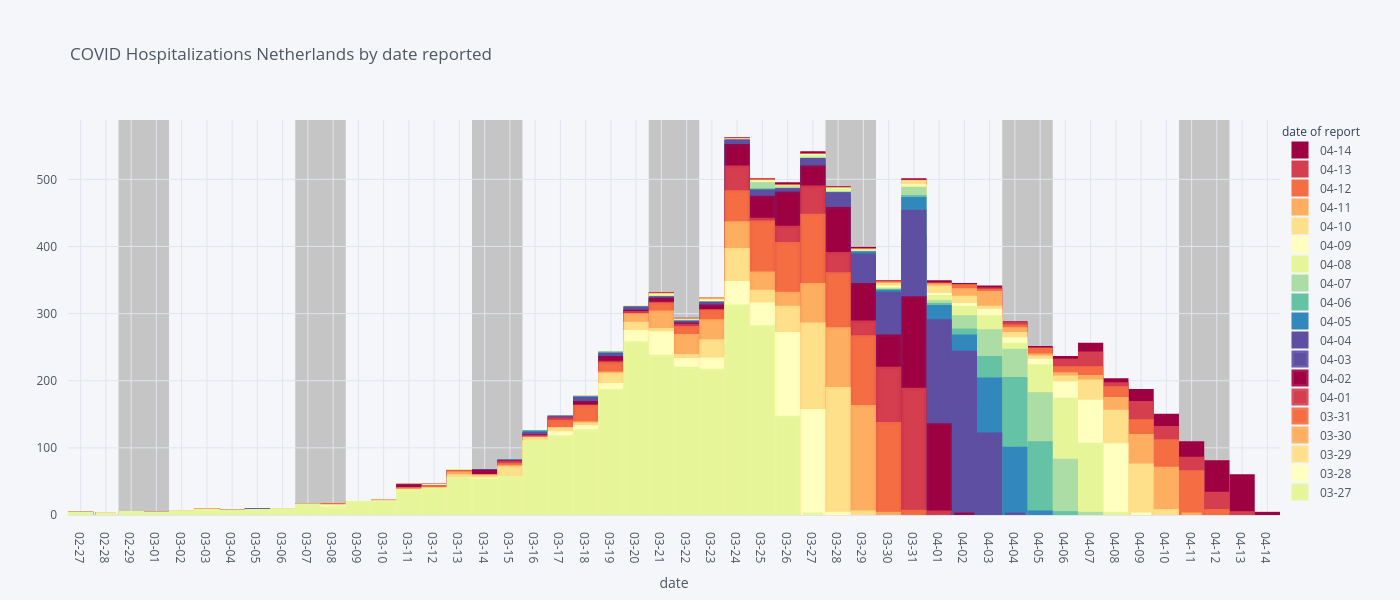

In [18]:
f.update_layout(legend=dict(x=1, y=1),
                margin=dict(
                    l=20,
                    r=120,
                    b=20,
                    t=120,
                    pad=10,
                    ),
                width=1400,
                height=600
                )

res = requests.post('http://localhost:9091', data=f.to_json())
from PIL import Image
im = Image.open(io.BytesIO(res.content))
im.save(f.layout['title']['text'] + '.png')
im